In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ROOT_DIR = "/content/drive/My Drive/Colab Notebooks/"


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.basics import *
from fastai.metrics import *


In [0]:
batchSize = 64
imgSize = 224
data = ImageDataBunch.from_folder(path=ROOT_DIR,train="Train Directory",ds_tfms=get_transforms(),valid="Val Directory",bs=batchSize,size=imgSize)

In [8]:
data.normalize(imagenet_stats)
data.classes

['Checked',
 'Colourblock',
 'Melange',
 'Patterned',
 'Printed',
 'abstract',
 'floral',
 'graphic',
 'polka dots',
 'solid',
 'striped',
 'typography']

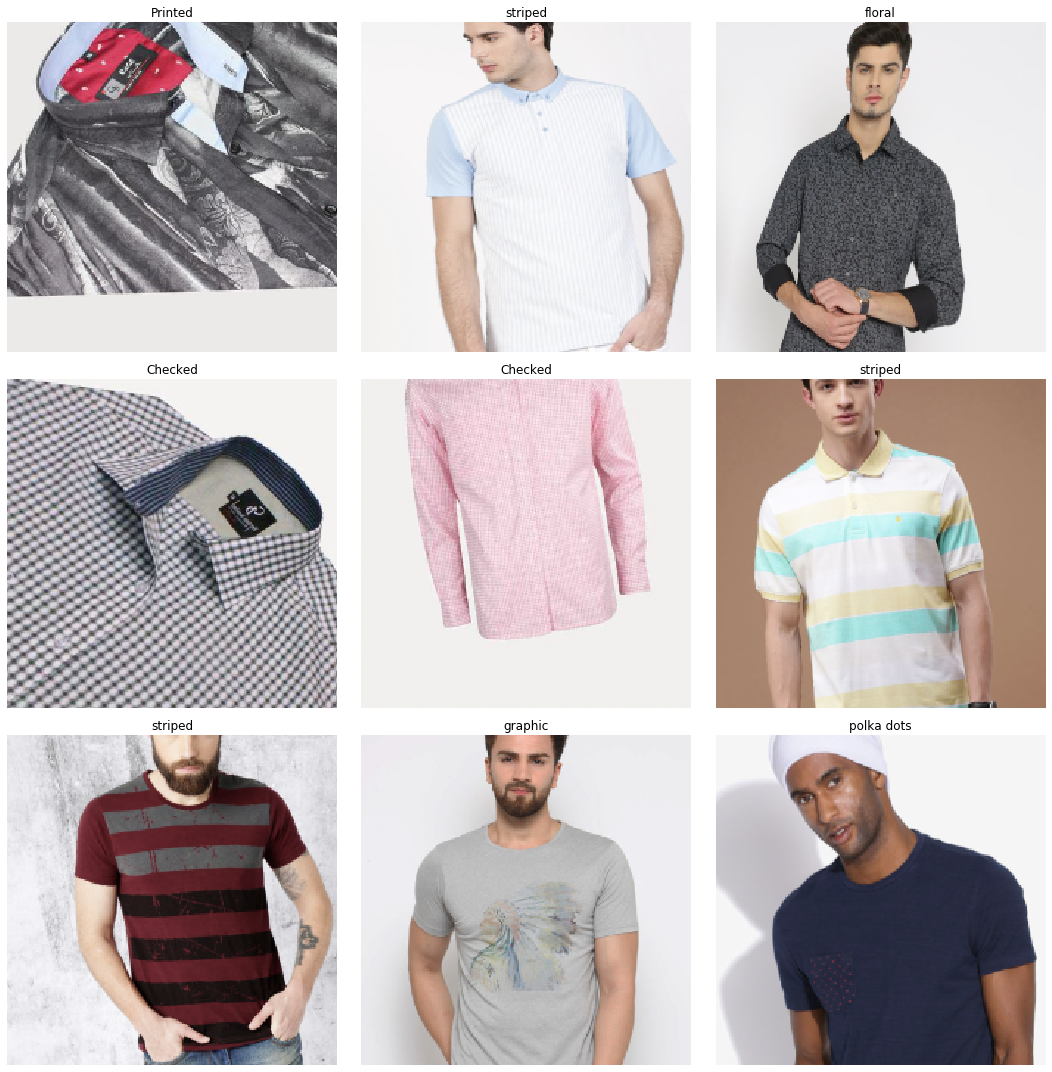

In [9]:
data.show_batch(3,figsize=(15,15))

In [10]:
print(data.classes)
len(data.classes),data.c

['Checked', 'Colourblock', 'Melange', 'Patterned', 'Printed', 'abstract', 'floral', 'graphic', 'polka dots', 'solid', 'striped', 'typography']


(12, 12)

In [0]:
learn = cnn_learner(data,models.resnet34,metrics=accuracy)
learn.model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 27.5MB/s]


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [0]:
learn.load('fynd-stage-1-weights')
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.631512,1.527656,0.556306,18:09
1,1.498762,1.434177,0.569820,17:01
2,1.254500,1.391533,0.565315,17:05


In [0]:
learn.save('fynd-stage-2-weights')

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.144452,1.368957,0.587838,17:03


In [0]:
learn.save('fynd-stage-2-weights')
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,1.086652,1.366624,0.601351,17:01
1,1.026054,1.246808,0.630631,17:00


Ok...after training for 6 epochs with resnet34, we can get a validation accuracy of 63.06%. The training loss did tank down to 0.9 for a while during 6th epoch. Also, the validation loss seems to go further down. So, i will try to achieve a lower loss on both train and validation sets. Then i will go for unfreezing the model and fine-tuning it.

In [0]:
#first, lets save the model just in case we start overfitting...
learn.save('fynd-stage-2-weights')

#Now, i train for 2 more epochs...
learn.fit_one_cycle(2)


epoch,train_loss,valid_loss,accuracy,time
0,0.977936,1.311066,0.596847,17:04
1,0.920828,1.229493,0.601351,17:15


In [0]:

# This model has lower val acc but also lower val loss...
# So deleting this seems a bit sketchy...lets save this model just in case we need it later.
learn.save('fynd-1.23valLoss-savedFrReview')


In [0]:
inter = ClassificationInterpretation.from_learner(learn)

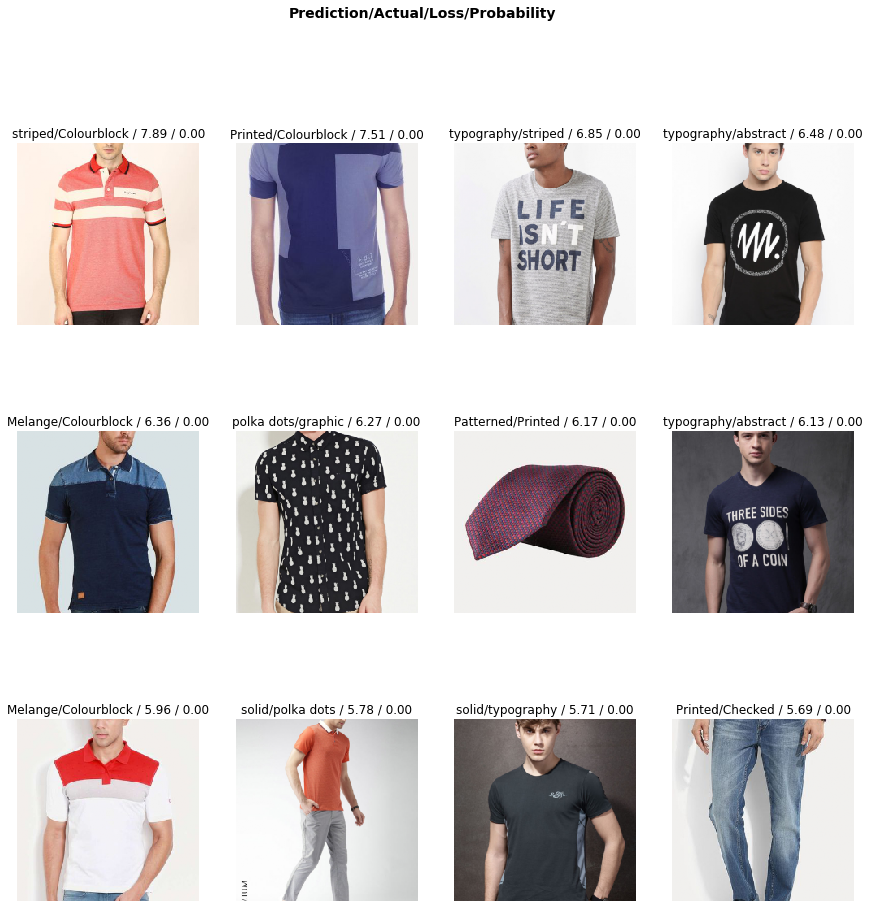

In [0]:
inter.plot_top_losses(12,figsize=(15,15))

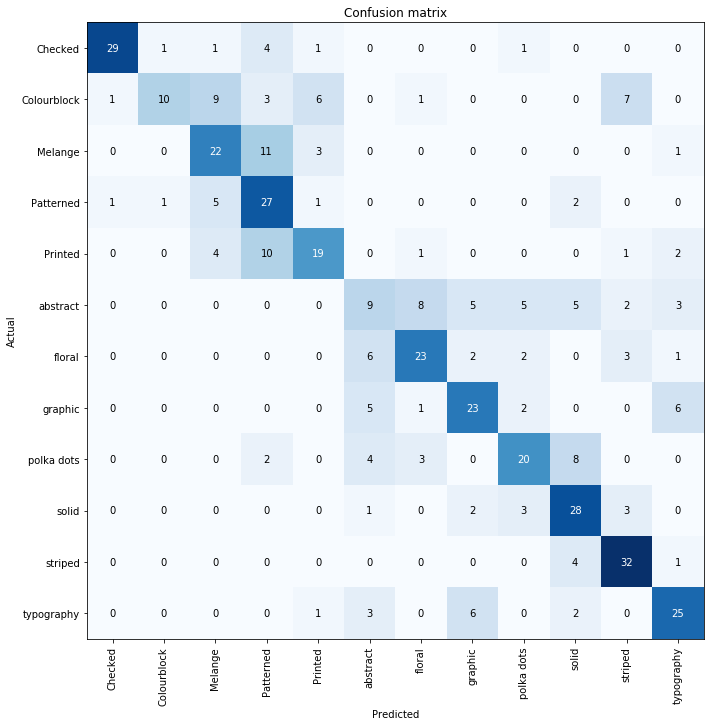

In [0]:
inter.plot_confusion_matrix(figsize=(10,10))

So, from the above matrix it can be seen that abstract and colorblock classes are the most misclassified classes. Many of our top losses(previous cell) can be seen to have multiple patterns. That is, the same colorblock Tshirt has stripes in it which causes misclassification. This can be resolved by using multi-label classification...labelling a cloth with multiple labels instead of just one.

Some specific classes like polka dots might be misclassified as the "dots" are either too small to be considered a dot or big enough to accomodate graphics and thereby being identified as a graphics type. A possible solution to this might be increasing the image resolution fed to the network. However, this would mean a higher chance of overfitting. So, more images need to be fed to the model.  

In [11]:
learn = cnn_learner(data=data,base_arch=models.resnet34,metrics=accuracy)
learn.load('fynd-stage-2-weights')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 68.3MB/s]


Learner(data=ImageDataBunch;

Train: LabelList (2927 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
polka dots,polka dots,polka dots,polka dots,polka dots
Path: /content/drive/My Drive/Colab Notebooks;

Valid: LabelList (444 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
abstract,abstract,abstract,abstract,abstract
Path: /content/drive/My Drive/Colab Notebooks;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [0]:
learn.unfreeze()
learn.lr_find()